In [1]:
import numpy as np
import pandas as pd
import csv
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
# PLOTTING 

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
sns.set_style(
    'whitegrid', 
    {
        'grid.color': '.95',
        'axes.spines.right': False,
        'axes.spines.top': False,
    }
)

params = {
    'axes.labelsize': 6,
    'axes.titlesize':6,
    'font.size': 5, 
    'legend.fontsize': 5,
    'xtick.labelsize': 6, 
    'ytick.labelsize': 6,
}

plt.rcParams.update(params)

In [4]:
palette_models = {  
    'HydrAMPZero': '#AF55FF',
    'HydrAMP': '#B80018',
    'BasicZero': '#1d3557',
    'Basic': '#660708',         
    'PepCVAEZero': '#A69FFF',
    'PepCVAE': '#0F5257'     
}

In [15]:
def get_charge_data():
    models = ['basic', 'pepcvae', 'hydramp', 'joker']
    data = []
    hydr_file = open('../../result/hydramp/case3_result.csv','r')
    basic_file = open('../../result/basic/case3_result.csv','r')
    pepcvae_file = open('../../result/pepcvae/case3_result.csv','r')
    hydr_reader = csv.reader(hydr_file)
    basic_reader = csv.reader(basic_file)
    pepcvae_reader = csv.reader(pepcvae_file)
    next(hydr_reader)
    next(basic_reader)
    next(pepcvae_reader)
    prototype_charge_list = []
    hydramp_charge_list = []
    hydramp_zero_charge_list = []
    basic_charge_list = []
    basic_zero_charge_list = []
    pepcvae_charge_list = []
    pepcvae_zero_charge_list = []

    for row in hydr_reader:
        _, t = row[0].split('_')
        if t == 'original':
            prototype_charge_list.append(float(row[7]))
        if t == 'HydrampOpt':
            hydramp_charge_list.append(float(row[7]))
        if t == 'HydrampZeroOpt':
            hydramp_zero_charge_list.append(float(row[7]))

    for row in basic_reader:
        _, t = row[0].split('_')
        if t == 'BasicOpt':
            basic_charge_list.append(float(row[7]))
        if t == 'BasicZeroOpt':
            basic_zero_charge_list.append(float(row[7]))

    for row in pepcvae_reader:
        _, t = row[0].split('_')
        if t == 'PepCVAEOpt':
            pepcvae_charge_list.append(float(row[7]))
        if t == 'PepCVAEZeroOpt':
            pepcvae_zero_charge_list.append(float(row[7]))

    data.append(hydramp_zero_charge_list)
    data.append(hydramp_charge_list)
    data.append(basic_zero_charge_list)
    data.append(basic_charge_list)
    data.append(pepcvae_zero_charge_list)  
    data.append(pepcvae_charge_list)  
    hydr_file.close()
    basic_file.close()
    pepcvae_file.close()  
    return prototype_charge_list, data
    

In [6]:
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value


def set_axis_style(ax, data, k):
    quartile1, medians, quartile3 = np.array([np.percentile(data_, [25, 50, 75], axis=0) for data_ in data]).T
    whiskers = np.array([
        adjacent_values(sorted_array, q1, q3)
        for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
    inds = np.arange(1, len(medians) + 1)
    ax.scatter(inds, medians, marker='o', lw=0.5, edgecolors='k', color='white', s=15, zorder=3)
    ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=0.5)
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks([3.5])
    ax.set_xticklabels([k])

In [7]:
def generate_classifier_distribution_plot(
    prototype_charge,
    optimized_charge,
):
    fig, (ax1, ax2) = plt.subplots(
        nrows=1, 
        ncols=2, 
        figsize=(6, 1.5),
        dpi=300,
        sharey=True,
        gridspec_kw={'width_ratios': [1, 6]}
    )

    ax1_parts = ax1.violinplot(
        dataset=prototype_charge,
        showmeans=False,
        showmedians=False,
        showextrema=False,
        widths=0.85, 

    )  
    set_axis_style(ax1, [prototype_charge], 'Charge before')


    for parts, color in zip([ax1_parts], ['#ffd23f']):
        for pc in parts['bodies']:
            pc.set_facecolor(color)
            pc.set_edgecolor('black')
            pc.set_linewidth(0.0)
            pc.set_alpha(1)   
    
    ax1.set_xticks([1])
    ax1.set_xticklabels(['Prototype'])
    ax1.set_ylabel('charge')

    parts2 = ax2.violinplot(
        dataset=optimized_charge,
        showmeans=False,
        showmedians=False,
        showextrema=False,
        widths=0.85, 
    )

    set_axis_style(ax2, optimized_charge, 'Optimized')
    ax2.spines['left'].set_visible(False)

    for parts in [parts2]:
        for pc, color in zip(parts['bodies'], palette_models.values()):
            pc.set_facecolor(color)
            pc.set_edgecolor('black')
            pc.set_linewidth(0.0)
            pc.set_alpha(1)
    
    for i, (label, ax) in enumerate(
    zip(['a'], [ax1])
    ):
        ax.annotate(label, xy=(-0.05, 1.2), xycoords='axes fraction',
          fontweight='bold', va='top', ha='right')

    return fig

In [8]:
def plot_classifier_distribution(data, prototype_charge):  
    optimized_charge = [x for x in data]
    
    fig = generate_classifier_distribution_plot(
        prototype_charge,
        optimized_charge,
    )
    return fig

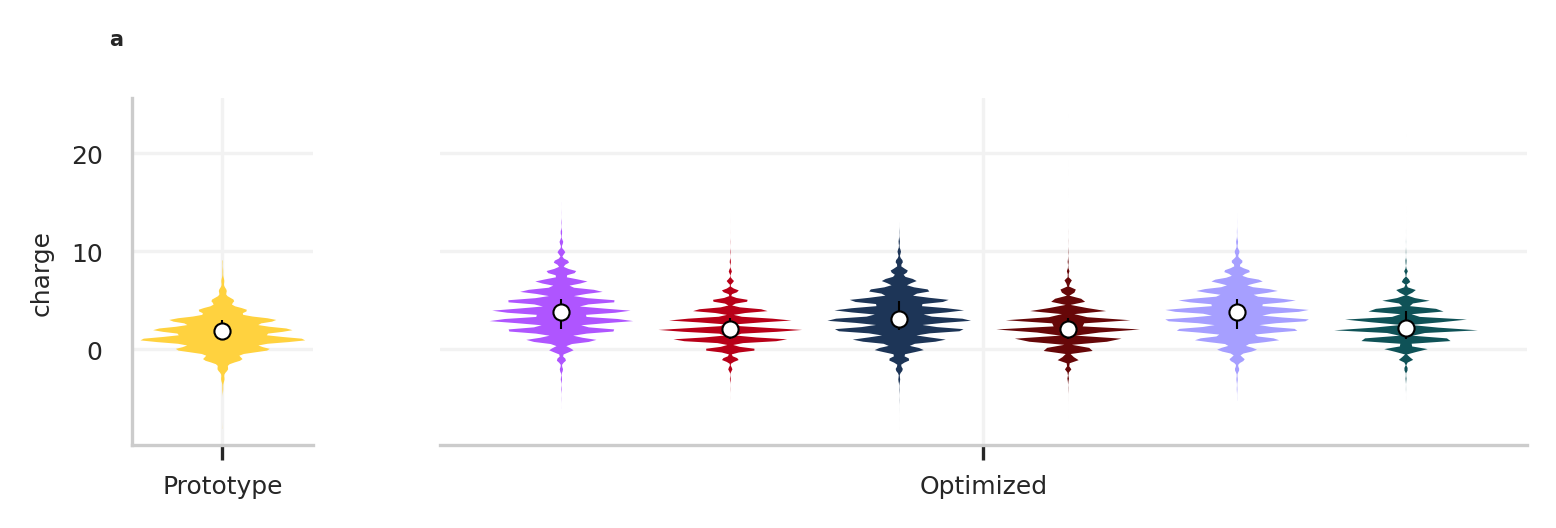

In [16]:
prototype_charge_list, data = get_charge_data()

fig = plot_classifier_distribution(data, prototype_charge_list)
fig.savefig("../figures/figure/case3_all_charge.pdf")
plt.show()